# Implementing Gradient Descent from scratch and using it to train a perceptron

I decided to implement the basic gradient descent algorithm for fun and to better understand the algorithm myself. I documented this in this notebook so that it might serve as useful or amusing to others, and because I have taken a liking to turning my projects into notebooks like these. 
(Note: I don't mean this to be a detailed and comprehensive lesson on the theory behind gradient descent. Perhaps I'll try my hand at that another day :) )

Gradient descent is an optimization algorithm that involves locating a minima of an error function. We start by picking a point to start with in the domain of our error function (BTW,  our error function maps points from the N-dimensional real number space to the real line, and is differentiable). We then compute the gradients of each component in our point. If our point is more than one dimension, we compute the all the partial derivatives with respect to each dimension. This resulting vector, when negated, describes a direction our point can move in where the function is decreasing. We then move that direction by adding each negated gradient multiplied by a learning rate to our point vector. We use a learning rate to control how far we move in each direction. 

One more component we will add is called momentum. Momentum works how it sounds like it might work. For each new movement, we will add a certain amount of the previous movement. This can help to make the algorithm move quickly when gradients are small.

Let's start by importing some necessary libraries!

In [1]:
import numpy as np
import math

### computing the vector of partial derivatives

Luckily we don't have to have a computer algebra system or know the error function's symbolic derivative to compute the partial derivates of a point on our function. We can approximate it with very good accuracy. Given that the derivative for a one dimensional function f can be computed by the expression 

$$\\lim \frac{f(x+h) - f(x)}{h}, h\rightarrow 0$$

we can calculate partial derivates by using a small h value. We'll define a function that returns the partial derivative value at any given point. It will accept an index so it knows which dimension we are differentiating with respect to.

In [2]:
def partial_deriv(f, x, idx):
    h = 0.000001
    x_ = np.array([v + h if i == idx else v for i,v in enumerate(x)])
    return (f(x_) - f(x))/h

### setting up our optimizer class

We will make a class for our gradient descent optimizer. In it's __init__ function, we'll set a few parameters such as the momentum, learning rate, starting point, and of course, a function to optimize for.

The gradientDescentOp.update function will iterate on the point. It will loop through each member of x, update it with the gradient change and the momentum, then save the gradient update to be used to compute the momentum of the next update.

Our gradientDescentOp.current function returns the current lowest function value encountered. We can extract the optimal point in our error function's domain by taking gradientDescentOp.x.

In [3]:
class gradientDescentOp:
    def __init__(self, f, x, lr, m):
        self.f = f
        self.x = x
        self.lr = lr
        self.m = m
        self.current_min = self.f(self.x)
        self.prev_updates = np.zeros(len(x))
        
    def update(self):
        x = list(self.x)
        for i in xrange(len(self.x)):
            gradient_update = -self.lr*partial_deriv(self.f, x, i)
            self.x[i] += self.m*self.prev_updates[i]
            self.x[i] +=  gradient_update
            self.prev_updates[i] = gradient_update
        self.current_min = self.f(self.x)
        
    def current(self):
        return self.current_min

### Testing it

Our optimizer is generalized to handle a function whose domain may be any power of the real numbers. Let's test our optimizer on some 3 dimensional functions to demonstrate it's effectiveness. Let's first focus on a simple 3D parabolic surface.

$$f(x,y) = x^{2} + y^{2}$$

we can implement the function for an N-dimensional parabolic surface with the following.

In [4]:
def parabola(x): return sum([i**2 for i in x])

Next, we will define our optimizer object and give it a learning rate of 0.2 and a momentum value of 0.0. Let's make our initial point be at (10,10).

In [5]:
op = gradientDescentOp(parabola, [10,10], 0.2, 0.0)

We will run our algorithm on this function and use a visual display to see it in action!
(The code to run the animation will be in this repo. It is rather unrefined and hacked up! (I am new to using matplotlib :P)

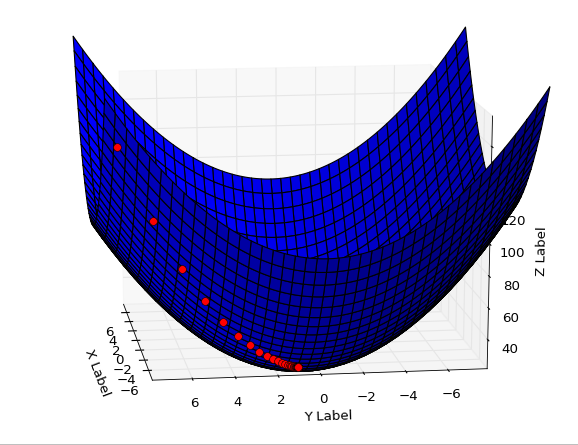

### Gained speed from momentum

The red dots represent the path taken to eventually reach the global minima that is the bottom of the surface. Let's rerun the algorithm with a 0.9 momentum value and see how it behaves differently.

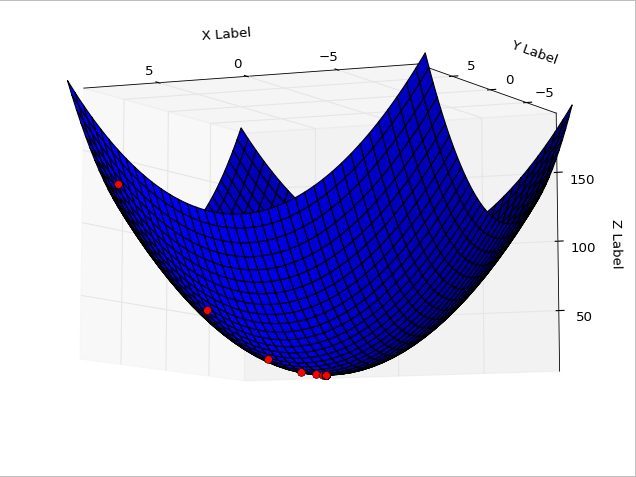

The process was much faster in converging to the minima! For long and shallow downhill slopes on functions, momentum can greatly boost efficiency.

### A more interesting function.

Below we can see the algorithm running on the function 

$$f(x,y) = \frac{sin(x)^{2} + cos(x)^{2}}{5+x^{2}+y^{2}}$$

with a learning rate of 0.5 and a momentum of 0.9. The algorithm was luckily able to escape a saddle point, one of the adversaries we face when using gradient descent.

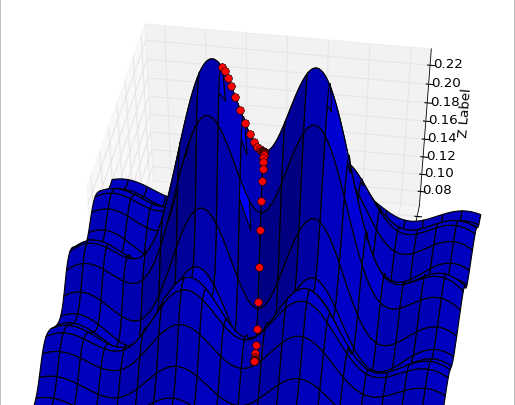



## Using the implementation to train a simple linear classifier

Let's apply our algorithm to train a linear classifier model. We will use Sklearn to generate a toy dataset consisting of 800 points on the real plane that belong to one of two clusters.

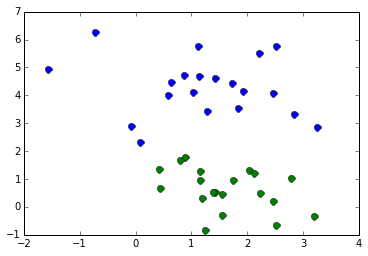

In [6]:
%matplotlib inline
from sklearn.datasets.samples_generator import make_blobs
import matplotlib.pyplot as plt

X, y = make_blobs(n_samples=40, centers=2, n_features=2, random_state=0)

for x,_y in zip(X,y):
    if(_y == 0):
        plt.plot([x[0]],[x[1]], marker = 'o', markersize=7, color='blue')
    else:
        plt.plot([x[0]],[x[1]], marker = 'o', markersize=7, color='green')

plt.show()

Our model will be a perceptron, or a single layer neural network with one output. Our model will find a line that separates the two clusters as accurately as possible. Because this isn't a serious effort with a real world dataset, we won't worry about dividing the data into a training and test set. Also, because our model is only a linear classifier, overfitting won't be an issue.

We will add a single bias component to each point so that one of our weights can act as a bias for each input neuron. This way, we won't have to optimize a second bias vector, we can just treat our model as one column vector of weights, which can be, in turn, can be transposed and viewed as one point in the 9 dimensional real number space.

In [7]:
# adding 1 so that our bias passes through uninhibited.
X = [np.append(x, [[1]]) for x in X]

Now we define a function to compute our model's output. Our model is so simple, as it can be represented purely as the normalization of one matrix multiplication. In this case, our normalization/activation will be done by tanh. We will initialize our weights to be zeros.

In [8]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def output(W, x, act):
    return act(np.matmul(x,np.transpose(W)))

w = np.zeros(3)

An error function will also be defined. We will use the mean squared error.

In [9]:
def error(w):
    mean_squared_error = 0
    N = len(X)
    for i in xrange(N):
        mean_squared_error += (output(w, X[i], sigmoid) - y[i])**2
    return mean_squared_error/N

We now have everything necessary to train the model with our gradient descent.

In [11]:
op = gradientDescentOp(error, w, 0.5, 0.9)

for i in xrange(800): op.update()
for i in xrange(8):
    print 'predicted by model: {} actual label: {}'.format(output(w, X[i], sigmoid), y[i])

predicted by model: 0.000465558734629 actual label: 0
predicted by model: 0.716984745322 actual label: 1
predicted by model: 0.999825165331 actual label: 1
predicted by model: 0.181920538193 actual label: 0
predicted by model: 1.46989848938e-05 actual label: 0
predicted by model: 0.98131102982 actual label: 1
predicted by model: 0.0515256064188 actual label: 0
predicted by model: 0.995770817818 actual label: 1


We have successfully been able train the linear model to classify whether or not a point is green or blue depending on whether or not it's output is above or below 0.5.